In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

# Defining some useful functions

In [141]:
def get_most_common_values(df:pd.DataFrame, col_name: str, n:int = None) -> pd.DataFrame:
    return df[df[col_name].isin(df[col_name].value_counts().head(n).index.tolist())]

def count_most_common_values(df:pd.DataFrame, col_name: str, n: int = None) -> int:
    return get_most_common_values(df=df, col_name=col_name, n=n).shape[0]

def plot_most_common_values(df:pd.DataFrame, col_name: str, n:int = None, kind: str = "bar") -> None:
    if kind == "bar" and n > 20:
        plt.figure(figsize=(10,3),dpi=200)
    else:
        plt.figure(figsize=(3,3),dpi=200)
    df[col_name].value_counts(dropna=False).head(n).plot(kind=kind,colors=get_color_list(plt.cm.RdPu_r, n=n),explode=[0.05]*n)
    plt.ylabel("")
    
def plot_representative(df:pd.DataFrame, col_name: str, xlabel: str, filename: str = None, n: int = None) -> None:
    population_representee_vocation = []
    for i in range(len(df[col_name].unique()) if n is None else n):
        X_vocation = count_most_common_values(df=df, col_name=col_name, n=i)
        Y_vocation = count_most_common_values(df=df, col_name="chef_vocation_norm_2")#count_most_common_values(df=df, col_name=col_name)
        population_representee_vocation.append(X_vocation/Y_vocation*100)
        #if population_representee_vocation[-1] > 50: break
    plt.figure(figsize=(3,3),dpi=200)
    plt.plot(population_representee_vocation,'-',color="#e36866",linewidth=4)
    #population_representee_vocation = np.array(population_representee_vocation)   
    #plt.hlines(y=50, xmin=0, xmax=np.argmin(np.abs(population_representee_vocation-50)))
    plt.xlabel(xlabel)
    plt.ylabel("Population active \n représentée [%]")
    plt.grid(visible=True, which="both")
    plt.ylim(0, 100)
    if n is not None:
        plt.xticks(np.arange(start=0, stop=n))
        #plt.xlim(0,n)
    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")

def get_color(base_color: list = [1, 0.3, 0.35], steps: int = 10) -> list:
    steps = steps + 1
    result = []
    base_color = np.array(base_color)
    for i in range(steps):
        #result.append(c*i/n)
        result.append([(base_color[j] + (1 - base_color[j]) * (i / (steps - 1))) for j in range(3)])
    return result[:-1]

def get_color_list(cmap, n):
    return get_color(steps=n)

# Preparing the data

In [171]:
# Loading data
recensement = pd.read_excel(io="data/1832_v4.xlsx", na_values=["·","?"])


classes = pd.read_excel(io="data/histoire urbaine digitale classification metiers.xlsx", sheet_name="data",  na_values="·")

# Adding the 'chef_vocation_categorie' column
classes = classes.rename(columns={"JOB": "chef_vocation_norm_2"})
classes = classes.rename(columns={"CLASS": "chef_vocation_categorie"})
recensement = recensement.merge(classes, on="chef_vocation_norm_2", how="outer")

# Split the values on the '/' character
split_vals = recensement['chef_vocation_categorie'].str.split('/')

# Create a new dataframe from the split values
recensement = recensement.assign(chef_vocation_categorie=split_vals).explode('chef_vocation_categorie')

# Some stats

Les cinq métiers les plus fréquents représentent 24% de la population.
Les cinq classes les plus fréquentes représentent 88% de la population.


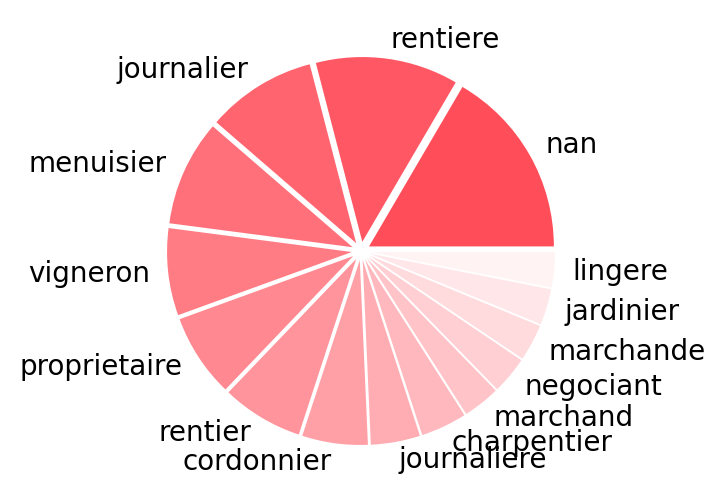

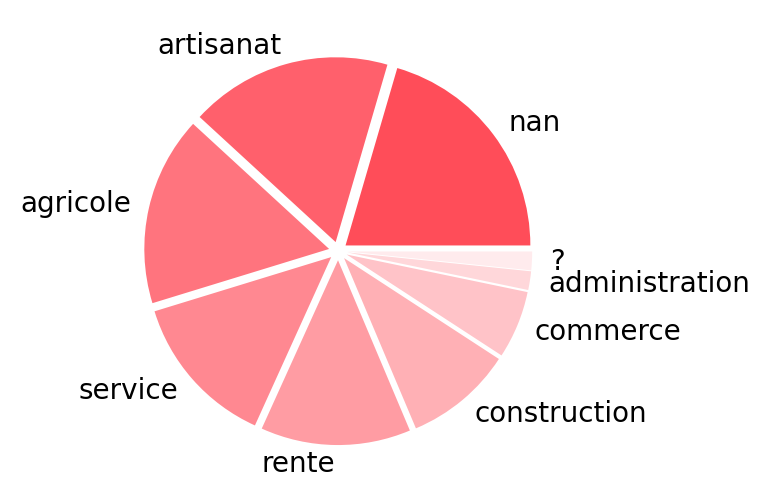

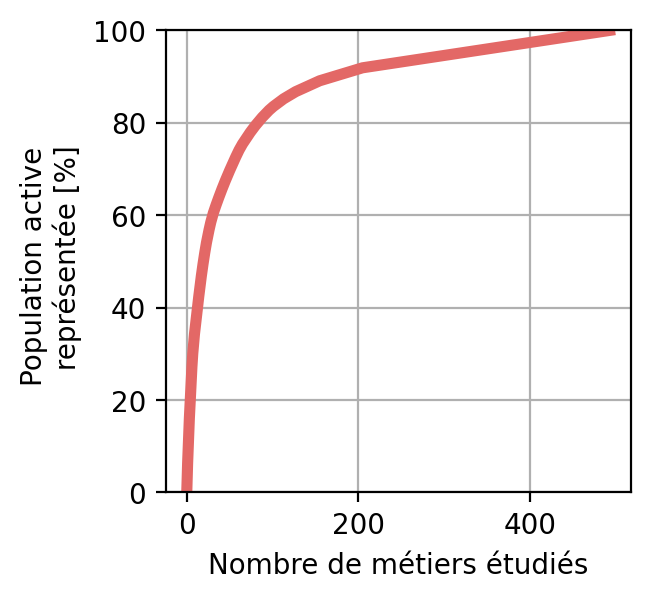

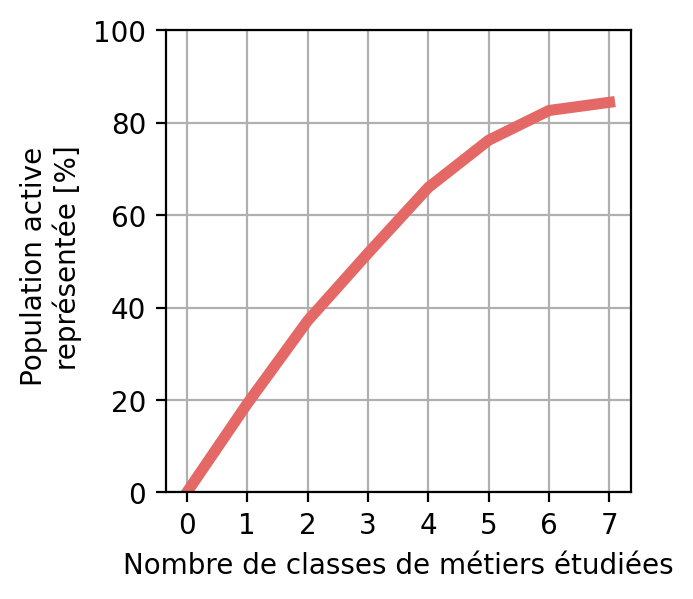

In [143]:
X_vocation = count_most_common_values(df=recensement, col_name="chef_vocation_norm_2", n=5)
Y_vocation = count_most_common_values(df=recensement, col_name="chef_vocation_norm_2")
print(f"Les cinq métiers les plus fréquents représentent {X_vocation/Y_vocation*100:.0f}% de la population.")
plot_most_common_values(df=recensement, col_name="chef_vocation_norm_2", n=15, kind="pie")

X_categorie = count_most_common_values(df=recensement, col_name="chef_vocation_categorie", n=5)
Y_categorie = count_most_common_values(df=recensement, col_name="chef_vocation_categorie")
print(f"Les cinq classes les plus fréquentes représentent {X_categorie/Y_categorie*100:.0f}% de la population.")
plot_most_common_values(df=recensement, col_name="chef_vocation_categorie", n=9, kind="pie")

plot_representative(recensement, "chef_vocation_norm_2", xlabel="Nombre de métiers étudiés", filename="./plots/pop_representee_vs_metiers.png")
plot_representative(recensement, "chef_vocation_categorie", xlabel="Nombre de classes de métiers étudiées", filename="./plots/pop_representee_vs_classes.png", n=8)


In [182]:
population_active_classifiee = count_most_common_values(df=recensement, col_name="chef_vocation_categorie", n=7)/recensement[~recensement["chef_vocation_norm_2"].isnull()].shape[0]
population_inactive = recensement[(recensement["chef_vocation_norm_2"].isnull())].shape[0] / recensement.shape[0]

([<matplotlib.patches.Wedge at 0x15981f670>,
 [Text(0.9543383628582358, 0.5470267719015792, 'Population \n inactive'),
  Text(-1.0960784889690935, -0.09280057122253572, 'Population \n active \n classifiée'),
  Text(1.0833489088502997, -0.1906702433335238, 'Population \n active \n non-clasifiée')],
 [Text(0.520548197922674, 0.2983782392190432, '8%'),
  Text(-0.5978609939831419, -0.05061849339411039, '78%'),
  Text(0.590917586645618, -0.1040019509091948, '14%')])

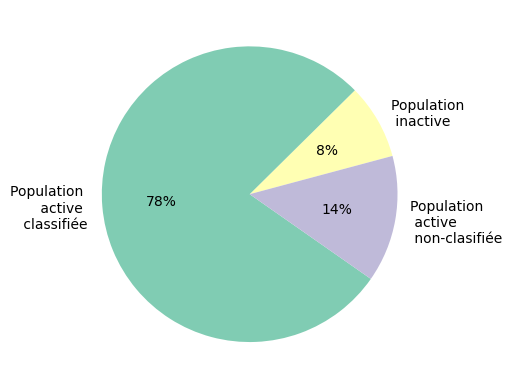

In [220]:
plt.pie(x=[population_inactive, (1-population_inactive)*population_active_classifiee, (1-population_inactive)*(1-population_active_classifiee)],
        labels=["Population \n inactive", "Population \n active \n classifiée", "Population \n active \n non-clasifiée"],startangle=15,
        colors=[(1,1,0.7), (0.5, 0.8, 0.7), (0.75, 0.73, 0.85)],autopct=lambda p: '{:.0f}%'.format(p))

In [181]:
population_inactive

318

In [178]:
recensement[recensement["chef_prenom"] == "gaspard"]

,Unnamed: 0,nom_rue,nom_rue_htr_corr,nom_rue_norm,nom_rue_norm_2,no_maison,proprietaire_nom,proprietaire_nom_corr,proprietaire_nom_htr_corr,proprietaire_nom_norm,...,pensionnaires_origine_htr_corr,pensionnaires_origine_norm,pensionnaires_condition,pensionnaires_condition_top_terms,pensionnaires_condition_htr_corr,pensionnaires_condition_norm,pensionnaires_recepisse,observations,Page,chef_vocation_categorie
746,2654,st etienne,st etienne,st etienne,st etienne,NaN,NaN,NaN,NaN,NaN,...,lutry,lutry,dom,domestique,dom,domestique,NaN,NaN,102,NaN
890,2714,lstopitat,lstopitat,lstopitat,rue de l'hopital,NaN,NaN,NaN,NaN,NaN,...,bernois id|·|incorpare,bernois id|·|incorpare,id id|·|pre,idem|idem|·|pre,id|·|pre,bussy-chardonney|·|menuisier,16797,NaN,104,agricole
2109,488,bepierre,bepierre,bepierre,st pierre,NaN,NaN,NaN,NaN,NaN,...,kohly,kohli,NaN,NaN,NaN,NaN,NaN,NaN,19,artisanat
3146,1237,rue du pre,rue du pre,rue du pre,rue du pre,NaN,NaN,NaN,NaN,NaN,...,dexe,dexe,pensionnaire,pensionnaire,pensionnaire,pensionnaires,1322,NaN,54,commerce
3593,3001,madelaine,madelaine,madeleine,madeleine,NaN,NaN,NaN,NaN,NaN,...,gollion,gollion,dque,dque,dque,domestique,3763,NaN,115,NaN
